# Homework 8

In [153]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

## 1 The task

In [154]:
def sequence_generator(length,num_samples):
  for sample in range(num_samples):
    sequence = list(np.random.randint(0,9, length))
    context = np.random.randint(0,9,2)
    count_1 = sequence.count(context[0].astype(int))
    count_2 = sequence.count(context[1].astype(int))
    label = [float(count_1>=count_2),float(count_2>=count_1)]
    context = tf.reshape(tf.one_hot(context, 10), (-1))
    sequence = tf.one_hot(sequence,10)
    sample = [tf.concat([context, elem],0) for elem in sequence]
    yield (tf.convert_to_tensor(sample), tf.reshape(tf.convert_to_tensor(label), (-1,)))

In [155]:
dataset = tf.data.Dataset.from_generator(sequence_generator, args=(25, 10000), output_signature=(tf.TensorSpec(shape=(25,30),dtype=tf.float32), tf.TensorSpec(shape=(2,),dtype=tf.float32))).cache().batch(64)

## 2 The Network

In [156]:
class LSTM_cell(tf.keras.Model):
  def __init__(self):
    super(LSTM_cell,self).__init__()
    
    self.forget_gate = tf.keras.layers.Dense(units=50, activation='sigmoid', bias_initializer='ones')
    self.input_gate = tf.keras.layers.Dense(units=50, activation='sigmoid')
    self.cell_state_candidates = tf.keras.layers.Dense(units=50, activation='tanh')
    self.output_gate = tf.keras.layers.Dense(units=50, activation='sigmoid')

  @tf.function
  def call(self, input, h_t, c_t):
    x_t = input

    # concatenate input and hidden state
    cell_input = tf.concat((x_t,h_t),1)

    # 1. Preparing
    f_t = self.forget_gate(cell_input)
    i_t = self.input_gate(cell_input)
    c_t = self.cell_state_candidates(cell_input)
    o_t = self.output_gate(cell_input)

    # 2. Updating the Cell state
    c_t = f_t*c_t + i_t*c_t

    # 3. Determining the hidden state/output
    h_t = o_t*tf.nn.tanh(c_t)
        
    return (h_t,c_t)

In [157]:
class LSTM(tf.keras.Model):
  def __init__(self):
    super(LSTM,self).__init__()

    self.readin_layer = tf.keras.layers.Dense(units=30)
    self.LSTM_cell = LSTM_cell()
    self.readout_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')

  @tf.function
  def call(self, input, h_t, c_t):
    x = self.readin_layer(input)
    
    # The input is expected to be of shape [batch size, timesteps, input size]
    timesteps = input.shape[1]
    # unrolling the LSTM cell
    for i in tf.range(timesteps):
      h_t, c_t = self.LSTM_cell(x[:,i,:], h_t, c_t)

    x = self.readout_layer(tf.convert_to_tensor(h_t))

    return(x)

In [158]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input, h_t=tf.zeros((input.shape[0],50)), c_t=tf.zeros((input.shape[0],50)))
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # accuracy for "binary" classification task
  accuracy = tf.reduce_mean(tf.cast(tf.argmax(target, axis = 1) == tf.argmax(prediction, axis = 1), tf.float32), axis=0)

  return loss, accuracy

In [159]:
tf.keras.backend.clear_session()

model = LSTM()

num_epochs=50
learning_rate=0.001
running_average_factor=0.95

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)
  
# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

# We train for num_epochs epochs.
for epoch in range(num_epochs):
      
  if epoch == 0:             
    start = time.time()       
    time_remaining="Unknown"
  else:
    now = time.time()                                         
    time_per_epoch = ((now-start)/epoch)                      
    remaining_epochs = num_epochs-epoch                  
    time_remaining = round(time_per_epoch*remaining_epochs,0)
  print('Epoch:',str(epoch + 1 ),"of",str(num_epochs)+". Time remaining:", time_remaining, "seconds")  

  # training
  running_average = 0
  accuracies = []

  for (input,target) in dataset:
    train_loss, accuracy = train_step(model, input, target, loss, optimizer)
    running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    accuracies.append(accuracy)

  train_losses.append(running_average.numpy())
  train_accuracies.append(np.mean(accuracies))

now = time.time()

Epoch: 1 of 50. Time remaining: Unknown seconds
Epoch: 2 of 50. Time remaining: 2687.0 seconds
Epoch: 3 of 50. Time remaining: 1412.0 seconds
Epoch: 4 of 50. Time remaining: 983.0 seconds
Epoch: 5 of 50. Time remaining: 767.0 seconds
Epoch: 6 of 50. Time remaining: 636.0 seconds
Epoch: 7 of 50. Time remaining: 547.0 seconds
Epoch: 8 of 50. Time remaining: 482.0 seconds
Epoch: 9 of 50. Time remaining: 432.0 seconds
Epoch: 10 of 50. Time remaining: 393.0 seconds
Epoch: 11 of 50. Time remaining: 361.0 seconds
Epoch: 12 of 50. Time remaining: 334.0 seconds
Epoch: 13 of 50. Time remaining: 311.0 seconds
Epoch: 14 of 50. Time remaining: 291.0 seconds
Epoch: 15 of 50. Time remaining: 273.0 seconds
Epoch: 16 of 50. Time remaining: 257.0 seconds
Epoch: 17 of 50. Time remaining: 242.0 seconds
Epoch: 18 of 50. Time remaining: 229.0 seconds
Epoch: 19 of 50. Time remaining: 217.0 seconds
Epoch: 20 of 50. Time remaining: 205.0 seconds
Epoch: 21 of 50. Time remaining: 195.0 seconds
Epoch: 22 of 50. T

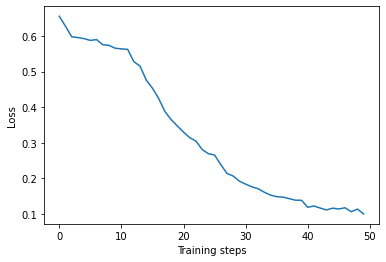

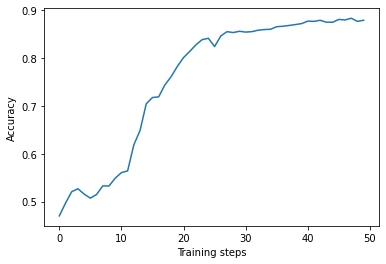

In [160]:
plt.figure()
plt.plot(train_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")

plt.figure()
plt.plot(train_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")

plt.show()